In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch import nn



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class DataLoader():
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        fileNames = os.listdir(self.img_dir)
        label = fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        image2 = read_image(img_path2)
        return image, image2

In [3]:
dataset = DataLoader("../Data/with_mask", "../Data/without_mask")

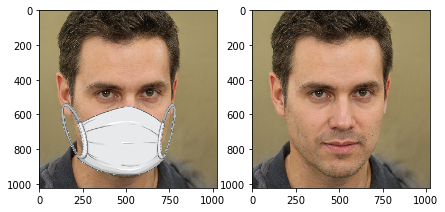

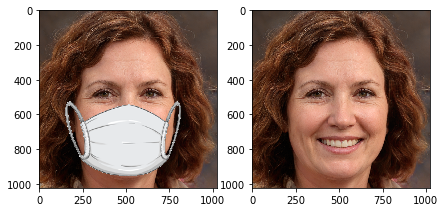

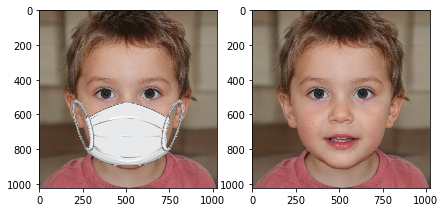

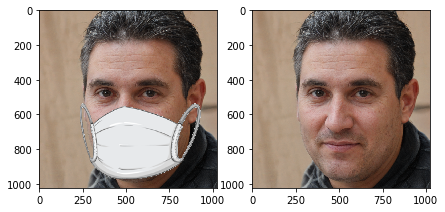

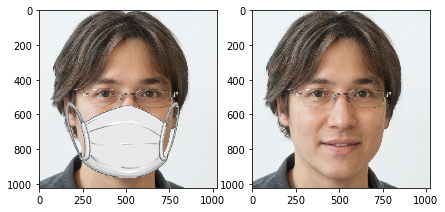

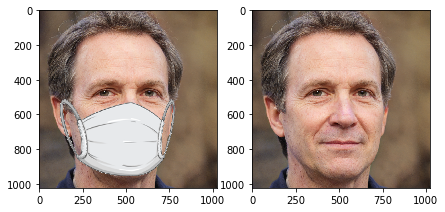

In [4]:
batch_size = 6
trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
# get some images
dataiter = iter(trainloader)

images, images2 = dataiter.next()
for image, image2 in zip(images,images2): # Run through all samples in a batch
    plt.figure(figsize = (7,7))
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(image2.numpy(), (1, 2, 0)))

Størrelsen på vores billeder

In [5]:
image.size()

torch.Size([3, 1024, 1024])

Vi bliver nok nødt til at resize vores billeder - de er for store => vi får for mange parametere vores model skal træne.

In [6]:
p = transforms.Compose([transforms.Scale((75,75))])

In [7]:
image_resize = p(image)

In [8]:
image_resize.size()

torch.Size([3, 75, 75])

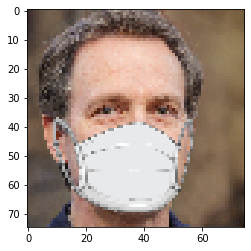

In [9]:
plt.imshow(np.transpose(image_resize.numpy(), (1, 2, 0)))

In [10]:
image_resize.view(-1).size()

torch.Size([16875])

Netværk - taget med inspiration fra VAE_exercise.ipynb.

In [58]:
bottleneck_size = 25


class VAE(nn.Module):
    def __init__(self):
        
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(16875, 50)
        self.fc21 = nn.Linear(50, bottleneck_size)
        self.fc22 = nn.Linear(50, bottleneck_size)
        self.fc3 = nn.Linear(bottleneck_size, 50)
        self.fc4 = nn.Linear(50, 16875)

    def encode(self, x):
        x  = x.view(-1)
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        log_sigma = self.fc22(h1)
        return mu, log_sigma

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        z = self.reparameterize(mu, log_sigma)
        return self.decode(z), mu, log_sigma


Initialisere klasse og optimizer

In [59]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

Data

In [65]:
batch_size = 20
trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
# get some images
dataiter = iter(trainloader)



In [63]:
def loss_function(recon_x, x, mu, z_log_sigma):
    loss = nn.MSELoss()
    print(recon_x.size())
    print(x.size())
    BCE = loss(recon_x, x)
    print(f"BCE: {BCE}")
    KLD = 0.5* torch.sum( z_log_sigma.exp() + mu.pow(2) - z_log_sigma   - 1)
    KLD *= 5
    
    return BCE + KLD

def draw(model):
    img = model(X_test)[0].detach().numpy()
    img = img.reshape((-1, 100, 100)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307

    axs[1].imshow(img, cmap='gray')
    fig.canvas.draw()


def train(epoch):
    vae.train()
    train_loss = 0
    
    dataiter = iter(trainloader)
    images, images2 = dataiter.next()
    for image, image2 in zip(images,images2): # Run through all samples in a batch
        img_mask = p(image).float()
        img_no_mask = p(image2).float()
        
        img_no_mask = img_no_mask.view(-1)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_sigma = vae(img_mask)
        print(recon_batch)
        #if batch_idx % 100 == 0:
        #    draw(vae)
        
        print(recon_batch[1])
        print(img_no_mask[1])
        loss = loss_function(recon_batch, img_no_mask, mu, log_sigma)
        
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    print(loss)    
    print(f"{epoch}: {train_loss / batch_size*16875}")

In [64]:
for epoch in range(1, 11):
    train(epoch)

tensor([ 3.1457e+12, -3.2019e+12, -3.4261e+12,  ...,  1.6247e+12,
        -2.4682e+12,  3.6678e+12], grad_fn=<AddBackward0>)
tensor(-3.2019e+12, grad_fn=<SelectBackward>)
tensor(123.)
torch.Size([16875])
torch.Size([16875])
BCE: 8.105792764510899e+24
tensor([-1.2969e+11, -4.4911e+10,  7.8272e+10,  ...,  7.8016e+10,
        -6.6170e+10, -3.6410e+10], grad_fn=<AddBackward0>)
tensor(-4.4911e+10, grad_fn=<SelectBackward>)
tensor(65.)
torch.Size([16875])
torch.Size([16875])
BCE: 3.651306908689512e+21
tensor([ 2.8194e+13, -2.0100e+13, -3.0652e+12,  ...,  3.1337e+13,
        -2.4412e+13,  9.3798e+11], grad_fn=<AddBackward0>)
tensor(-2.0100e+13, grad_fn=<SelectBackward>)
tensor(168.)
torch.Size([16875])
torch.Size([16875])
BCE: 5.7917526448084614e+26
tensor([-2.6209e+13, -1.7501e+13, -1.1997e+13,  ...,  1.1883e+13,
        -6.2983e+12, -1.4016e+12], grad_fn=<AddBackward0>)
tensor(-1.7501e+13, grad_fn=<SelectBackward>)
tensor(155.)
torch.Size([16875])
torch.Size([16875])
BCE: 7.854329401017551e

tensor([-2.2292e+12, -7.7656e+11, -6.7911e+11,  ...,  9.6057e+11,
        -5.8455e+11, -9.5818e+10], grad_fn=<AddBackward0>)
tensor(-7.7656e+11, grad_fn=<SelectBackward>)
tensor(173.)
torch.Size([16875])
torch.Size([16875])
BCE: 6.31456837455427e+23
tensor([-4.1592e+12, -2.1641e+12,  4.5941e+11,  ...,  1.6138e+12,
        -1.4831e+12,  7.9573e+11], grad_fn=<AddBackward0>)
tensor(-2.1641e+12, grad_fn=<SelectBackward>)
tensor(135.)
torch.Size([16875])
torch.Size([16875])
BCE: 2.6217613717592914e+24
tensor([ 1.7479e+15, -9.5726e+15, -1.0208e+16,  ...,  4.3831e+15,
        -4.9277e+15,  5.6989e+15], grad_fn=<AddBackward0>)
tensor(-9.5726e+15, grad_fn=<SelectBackward>)
tensor(239.)
torch.Size([16875])
torch.Size([16875])
BCE: 3.9744570292249733e+31
tensor([-3.3555e+12, -1.9066e+12, -5.7278e+11,  ...,  1.5191e+12,
        -1.0016e+12,  2.9658e+11], grad_fn=<AddBackward0>)
tensor(-1.9066e+12, grad_fn=<SelectBackward>)
tensor(123.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.408365963701677

tensor([-1.4765e+14, -9.7357e+13, -6.5953e+13,  ...,  6.7364e+13,
        -3.6558e+13, -6.5020e+12], grad_fn=<AddBackward0>)
tensor(-9.7357e+13, grad_fn=<SelectBackward>)
tensor(165.)
torch.Size([16875])
torch.Size([16875])
BCE: 2.489231389209454e+27
tensor([ 1.8438e+09, -2.0739e+10,  1.2288e+10,  ...,  1.3307e+09,
        -3.9451e+09, -7.4409e+09], grad_fn=<AddBackward0>)
tensor(-2.0739e+10, grad_fn=<SelectBackward>)
tensor(65.)
torch.Size([16875])
torch.Size([16875])
BCE: 8.84066370516083e+19
tensor([-1.8455e+12, -3.0248e+12,  6.8229e+11,  ...,  2.7333e+12,
        -2.0161e+12, -2.4266e+12], grad_fn=<AddBackward0>)
tensor(-3.0248e+12, grad_fn=<SelectBackward>)
tensor(123.)
torch.Size([16875])
torch.Size([16875])
BCE: 3.950165888048209e+24
tensor([ 3.1165e+15, -1.8952e+16, -2.0240e+16,  ...,  8.6591e+15,
        -9.5787e+15,  1.1093e+16], grad_fn=<AddBackward0>)
tensor(-1.8952e+16, grad_fn=<SelectBackward>)
tensor(239.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.5295964881175078e+

        -5.1061e+11, -1.8907e+11], grad_fn=<AddBackward0>)
tensor(-9.2822e+11, grad_fn=<SelectBackward>)
tensor(21.)
torch.Size([16875])
torch.Size([16875])
BCE: 2.5688195405269182e+23
tensor(2.1808e+26, grad_fn=<AddBackward0>)
6: 7.274411040258127e+37
tensor([ 6.1589e+14, -1.6794e+15, -1.8060e+15,  ...,  7.8643e+14,
        -9.3096e+14,  1.1988e+15], grad_fn=<AddBackward0>)
tensor(-1.6794e+15, grad_fn=<SelectBackward>)
tensor(146.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.3972125403578763e+30
tensor([-1.2628e+14, -8.3139e+13, -5.5905e+13,  ...,  5.7621e+13,
        -3.1352e+13, -5.3228e+12], grad_fn=<AddBackward0>)
tensor(-8.3139e+13, grad_fn=<SelectBackward>)
tensor(165.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.820641398895916e+27
tensor([ 1.7752e+13, -1.4215e+13, -1.4849e+12,  ...,  2.2076e+13,
        -1.6546e+13, -1.3036e+12], grad_fn=<AddBackward0>)
tensor(-1.4215e+13, grad_fn=<SelectBackward>)
tensor(155.)
torch.Size([16875])
torch.Size([16875])
BCE: 2.7499496640603

        -1.7350e+15,  2.2106e+15], grad_fn=<AddBackward0>)
tensor(-3.1549e+15, grad_fn=<SelectBackward>)
tensor(146.)
torch.Size([16875])
torch.Size([16875])
BCE: 4.863975822138934e+30
tensor([-1.8835e+10, -1.5333e+10,  1.5412e+10,  ...,  1.1588e+10,
        -1.1802e+10, -4.5980e+09], grad_fn=<AddBackward0>)
tensor(-1.5333e+10, grad_fn=<SelectBackward>)
tensor(76.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.1787149918633093e+20
tensor(3.5686e+24, grad_fn=<AddBackward0>)
8: 7.271195734683074e+37
tensor([-6.0055e+15, -4.4801e+15,  4.5456e+15,  ...,  4.2075e+15,
        -3.7618e+15, -2.0567e+15], grad_fn=<AddBackward0>)
tensor(-4.4801e+15, grad_fn=<SelectBackward>)
tensor(239.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.198891130848918e+31
tensor([ 4.4950e+10, -1.4629e+11, -1.5040e+11,  ...,  6.5529e+10,
        -8.1495e+10,  9.4926e+10], grad_fn=<AddBackward0>)
tensor(-1.4629e+11, grad_fn=<SelectBackward>)
tensor(65.)
torch.Size([16875])
torch.Size([16875])
BCE: 1.030538098762895

tensor([ 1.3963e+14, -2.4180e+14, -2.2546e+13,  ...,  3.6228e+14,
        -2.4910e+14, -1.1859e+14], grad_fn=<AddBackward0>)
tensor(-2.4180e+14, grad_fn=<SelectBackward>)
tensor(119.)
torch.Size([16875])
torch.Size([16875])
BCE: 6.180634197253088e+28
tensor(2.4183e+31, grad_fn=<AddBackward0>)
10: 7.267164573180255e+37


In [143]:
dataiter = iter(trainloader)

images, images2 = dataiter.next()

for image, image2 in zip(images,images2): # Run through all samples in a batch
    img_mask = p(image).float()
    img_no_mask = p(image2).float()
     

In [66]:
dataiter = iter(trainloader)
images, images2 = dataiter.next()
for image, image2 in zip(images,images2): # Run through all samples in a batch
    img_mask = p(image).float()
    img_no_mask = p(image2).float()
             
    recon_batch, mu, log_sigma = vae(img_mask)
     

In [69]:
out = recon_batch.view(3,75,75).deta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


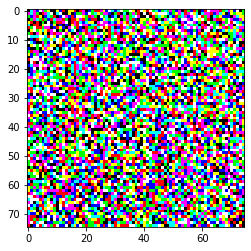

In [71]:
plt.imshow(np.transpose(out.detach().numpy(), (1, 2, 0)))